In [13]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torch
import random
from PIL import Image, ImageOps, ImageFilter
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
from torch.utils import data
import time
import copy
from tqdm import tqdm

In [14]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Apr 29 15:50:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    42W / 300W |   1421MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")
    print("You may want to try to use the GPU in Google Colab by clicking in:")
    print("Runtime > Change Runtime type > Hardware accelerator > GPU.")

Using the GPU!


Downloading the pacakges of U-net

In [17]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch
import segmentation_models_pytorch as smp

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-enmzjbgy
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-enmzjbgy
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


import dataset from mit

In [ ]:
#!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
#!unzip ADEChallengeData2016.zip && rm ADEChallengeData2016.zip
#!mv /content/ADEChallengeData2016 /content/drive/MyDrive/6.869

In [ ]:
#!unzip ADEChallengeData2016.zip
#!mv /content/ADEChallengeData2016 /content/drive/MyDrive/6.869

In [18]:
TARGET_GOOGLE_DRIVE_DIR = '/content/drive/MyDrive/6.869/ADEChallengeData2016'

Show some images

#Take a Look on Dataset

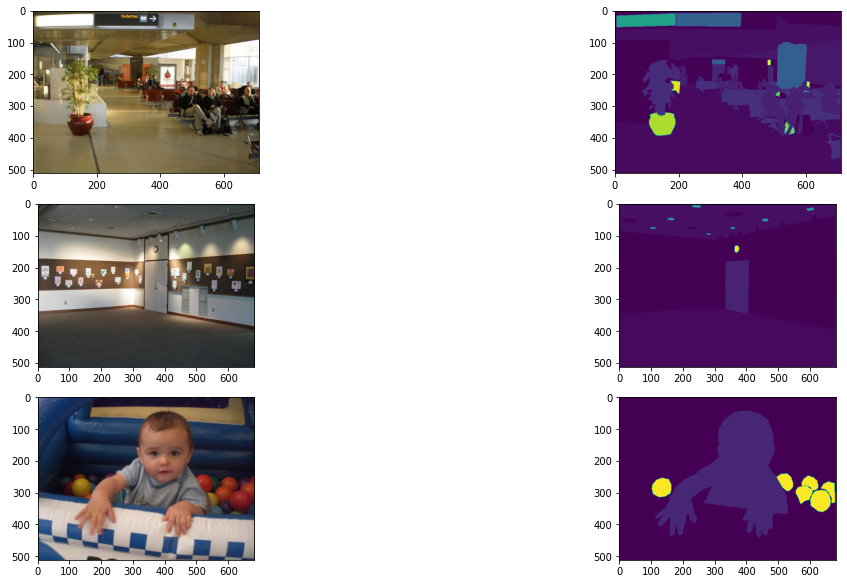

In [ ]:
image_name_list = ["ADE_train_00000002","ADE_train_00000003","ADE_train_00000005"]
fig, axs = plt.subplots(len(image_name_list), 2, figsize=(16, 8), constrained_layout=True)
for i,image_name in enumerate(image_name_list):
  original_image = os.path.join(TARGET_GOOGLE_DRIVE_DIR,"images","training",f"{image_name}.jpg")
  label_image = os.path.join(TARGET_GOOGLE_DRIVE_DIR, "annotations", "training", f"{image_name}.png")
  original_img = Image.open(original_image).convert('RGB')
  mask_img = Image.open(label_image)

  axs[i,0].imshow(original_img)
  axs[i,0].grid(False)

  label_image = np.asarray(mask_img)
  axs[i,1].imshow(label_image)
  axs[i,1].grid(False)


In [19]:
class SegmentationDataset(object):
    """Segmentation Base Dataset"""

    def __init__(self, root, split, mode, transform, base_size=520, crop_size=480):
        super(SegmentationDataset, self).__init__()
        self.root = root
        self.transform = transform
        self.split = split
        self.mode = mode if mode is not None else split
        self.base_size = base_size
        self.crop_size = crop_size

    def _val_sync_transform(self, img, mask):
        outsize = self.crop_size
        short_size = outsize
        w, h = img.size
        if w > h:
            oh = short_size
            ow = int(1.0 * w * oh / h)
        else:
            ow = short_size
            oh = int(1.0 * h * ow / w)
        img = img.resize((ow, oh), Image.BILINEAR)
        mask = mask.resize((ow, oh), Image.NEAREST)
        # center crop
        w, h = img.size
        x1 = int(round((w - outsize) / 2.))
        y1 = int(round((h - outsize) / 2.))
        img = img.crop((x1, y1, x1 + outsize, y1 + outsize))
        mask = mask.crop((x1, y1, x1 + outsize, y1 + outsize))
        # final transform
        img, mask = self._img_transform(img), self._mask_transform(mask)
        return img, mask

    def _sync_transform(self, img, mask):
        # random mirror
        if random.random() < 0.5:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
            mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
        crop_size = self.crop_size
        # random scale (short edge)
        short_size = random.randint(int(self.base_size * 0.5), int(self.base_size * 2.0))
        w, h = img.size
        if h > w:
            ow = short_size
            oh = int(1.0 * h * ow / w)
        else:
            oh = short_size
            ow = int(1.0 * w * oh / h)
        img = img.resize((ow, oh), Image.BILINEAR)
        mask = mask.resize((ow, oh), Image.NEAREST)
        # pad crop
        if short_size < crop_size:
            padh = crop_size - oh if oh < crop_size else 0
            padw = crop_size - ow if ow < crop_size else 0
            img = ImageOps.expand(img, border=(0, 0, padw, padh), fill=0)
            mask = ImageOps.expand(mask, border=(0, 0, padw, padh), fill=0)
        # random crop crop_size
        w, h = img.size
        x1 = random.randint(0, w - crop_size)
        y1 = random.randint(0, h - crop_size)
        img = img.crop((x1, y1, x1 + crop_size, y1 + crop_size))
        mask = mask.crop((x1, y1, x1 + crop_size, y1 + crop_size))
        # gaussian blur as in PSP
        if random.random() < 0.5:
            img = img.filter(ImageFilter.GaussianBlur(radius=random.random()))
        # final transform
        img, mask = self._img_transform(img), self._mask_transform(mask)
        return img, mask

    def _img_transform(self, img):
        return np.array(img)

    def _mask_transform(self, mask):
        return np.array(mask).astype('int32')

    @property
    def num_class(self):
        """Number of categories."""
        return self.NUM_CLASS

    @property
    def pred_offset(self):
        return 0

In [20]:

class ADE20KSegmentation(SegmentationDataset):
    """ADE20K Semantic Segmentation Dataset.
    Parameters
    ----------
    root : string
        Path to ADE20K folder. Default is './datasets/ade'
    split: string
        'train', 'val' or 'test'
    transform : callable, optional
        A function that transforms the image
    Examples
    --------
    >>> from torchvision import transforms
    >>> import torch.utils.data as data
    >>> # Transforms for Normalization
    >>> input_transform = transforms.Compose([
    >>>     transforms.ToTensor(),
    >>>     transforms.Normalize((.485, .456, .406), (.229, .224, .225)),
    >>> ])
    >>> # Create Dataset
    >>> trainset = ADE20KSegmentation(split='train', transform=input_transform)
    >>> # Create Training Loader
    >>> train_data = data.DataLoader(
    >>>     trainset, 4, shuffle=True,
    >>>     num_workers=4)
    """
    BASE_DIR = 'ADEChallengeData2016'
    NUM_CLASS = 150

    def __init__(self, root='/content/drive/MyDrive/6.869', split='train', mode=None, transform=None, **kwargs):
        super(ADE20KSegmentation, self).__init__(root, split, mode, transform, **kwargs)
        root = os.path.join(root, self.BASE_DIR)
        self.images, self.masks = _get_ade20k_pairs(root, split)
        assert (len(self.images) == len(self.masks))
        if len(self.images) == 0:
            raise RuntimeError("Found 0 images in subfolders of:" + root + "\n")
        print('Found {} images in the folder {}'.format(len(self.images), root))

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert('RGB')
        if self.mode == 'test':
            img = self._img_transform(img)
            if self.transform is not None:
                img = self.transform(img)
            return img, os.path.basename(self.images[index])
        mask = Image.open(self.masks[index])
        # synchrosized transform
        if self.mode == 'train':
            img, mask = self._sync_transform(img, mask)
        elif self.mode == 'val':
            img, mask = self._val_sync_transform(img, mask)
        else:
            assert self.mode == 'testval'
            img, mask = self._img_transform(img), self._mask_transform(mask)
        # general resize, normalize and to Tensor
        if self.transform is not None:
            img = self.transform(img)
        return img, mask, os.path.basename(self.images[index])

    def _mask_transform(self, mask):
        return torch.LongTensor(np.array(mask).astype('int32') - 1)

    def __len__(self):
        return len(self.images)

    @property
    def pred_offset(self):
        return 1

    @property
    def classes(self):
        """Category names."""
        return ("wall", "building, edifice", "sky", "floor, flooring", "tree",
                "ceiling", "road, route", "bed", "windowpane, window", "grass",
                "cabinet", "sidewalk, pavement",
                "person, individual, someone, somebody, mortal, soul",
                "earth, ground", "door, double door", "table", "mountain, mount",
                "plant, flora, plant life", "curtain, drape, drapery, mantle, pall",
                "chair", "car, auto, automobile, machine, motorcar",
                "water", "painting, picture", "sofa, couch, lounge", "shelf",
                "house", "sea", "mirror", "rug, carpet, carpeting", "field", "armchair",
                "seat", "fence, fencing", "desk", "rock, stone", "wardrobe, closet, press",
                "lamp", "bathtub, bathing tub, bath, tub", "railing, rail", "cushion",
                "base, pedestal, stand", "box", "column, pillar", "signboard, sign",
                "chest of drawers, chest, bureau, dresser", "counter", "sand", "sink",
                "skyscraper", "fireplace, hearth, open fireplace", "refrigerator, icebox",
                "grandstand, covered stand", "path", "stairs, steps", "runway",
                "case, display case, showcase, vitrine",
                "pool table, billiard table, snooker table", "pillow",
                "screen door, screen", "stairway, staircase", "river", "bridge, span",
                "bookcase", "blind, screen", "coffee table, cocktail table",
                "toilet, can, commode, crapper, pot, potty, stool, throne",
                "flower", "book", "hill", "bench", "countertop",
                "stove, kitchen stove, range, kitchen range, cooking stove",
                "palm, palm tree", "kitchen island",
                "computer, computing machine, computing device, data processor, "
                "electronic computer, information processing system",
                "swivel chair", "boat", "bar", "arcade machine",
                "hovel, hut, hutch, shack, shanty",
                "bus, autobus, coach, charabanc, double-decker, jitney, motorbus, "
                "motorcoach, omnibus, passenger vehicle",
                "towel", "light, light source", "truck, motortruck", "tower",
                "chandelier, pendant, pendent", "awning, sunshade, sunblind",
                "streetlight, street lamp", "booth, cubicle, stall, kiosk",
                "television receiver, television, television set, tv, tv set, idiot "
                "box, boob tube, telly, goggle box",
                "airplane, aeroplane, plane", "dirt track",
                "apparel, wearing apparel, dress, clothes",
                "pole", "land, ground, soil",
                "bannister, banister, balustrade, balusters, handrail",
                "escalator, moving staircase, moving stairway",
                "ottoman, pouf, pouffe, puff, hassock",
                "bottle", "buffet, counter, sideboard",
                "poster, posting, placard, notice, bill, card",
                "stage", "van", "ship", "fountain",
                "conveyer belt, conveyor belt, conveyer, conveyor, transporter",
                "canopy", "washer, automatic washer, washing machine",
                "plaything, toy", "swimming pool, swimming bath, natatorium",
                "stool", "barrel, cask", "basket, handbasket", "waterfall, falls",
                "tent, collapsible shelter", "bag", "minibike, motorbike", "cradle",
                "oven", "ball", "food, solid food", "step, stair", "tank, storage tank",
                "trade name, brand name, brand, marque", "microwave, microwave oven",
                "pot, flowerpot", "animal, animate being, beast, brute, creature, fauna",
                "bicycle, bike, wheel, cycle", "lake",
                "dishwasher, dish washer, dishwashing machine",
                "screen, silver screen, projection screen",
                "blanket, cover", "sculpture", "hood, exhaust hood", "sconce", "vase",
                "traffic light, traffic signal, stoplight", "tray",
                "ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, "
                "dustbin, trash barrel, trash bin",
                "fan", "pier, wharf, wharfage, dock", "crt screen",
                "plate", "monitor, monitoring device", "bulletin board, notice board",
                "shower", "radiator", "glass, drinking glass", "clock", "flag")


def _get_ade20k_pairs(folder, mode='train'):
    img_paths = []
    mask_paths = []
    if mode == 'train':
        img_folder = os.path.join(folder, 'images/training')
        mask_folder = os.path.join(folder, 'annotations/training')
    else:
        img_folder = os.path.join(folder, 'images/validation')
        mask_folder = os.path.join(folder, 'annotations/validation')
    for filename in os.listdir(img_folder):
        basename, _ = os.path.splitext(filename)
        if filename.endswith(".jpg"):
            imgpath = os.path.join(img_folder, filename)
            maskname = basename + '.png'
            maskpath = os.path.join(mask_folder, maskname)
            if os.path.isfile(maskpath):
                img_paths.append(imgpath)
                mask_paths.append(maskpath)
            else:
                print('cannot find the mask:', maskpath)

    return img_paths, mask_paths


if __name__ == '__main__':
    train_dataset = ADE20KSegmentation()

Found 20210 images in the folder /content/drive/MyDrive/6.869/ADEChallengeData2016


#Fully Convolutional Networks

In [21]:
FCN_model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


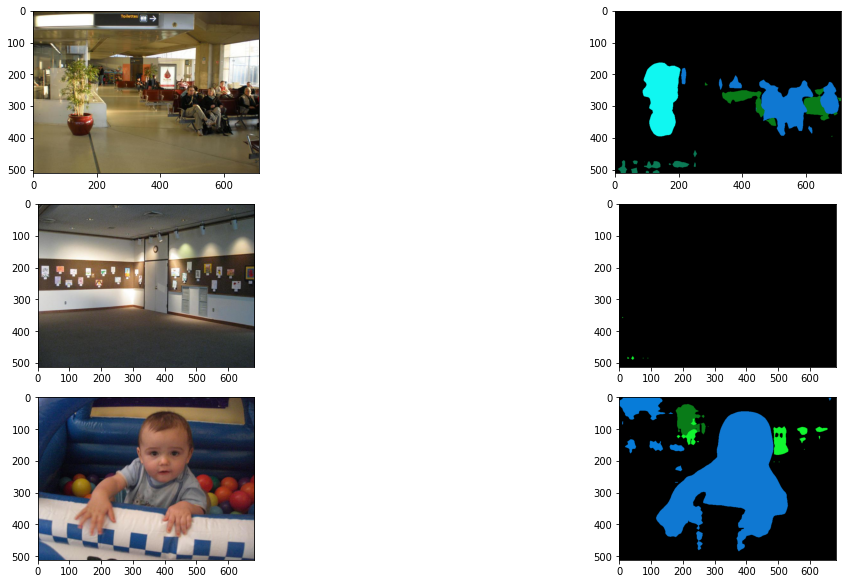

In [ ]:
image_name_list = ["ADE_train_00000002","ADE_train_00000003","ADE_train_00000005"]

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

FCN_model.to('cuda')
fig, axs = plt.subplots(len(image_name_list), 2, figsize=(16, 8), constrained_layout=True)

for i,image_name in enumerate(image_name_list):
  input_image = os.path.join(TARGET_GOOGLE_DRIVE_DIR,"images","training",f"{image_name}.jpg")
  input_image = Image.open(input_image).convert('RGB')

  input_tensor = preprocess(input_image)
  #add batch dimension
  input_batch = input_tensor.unsqueeze(0)


  input_batch = input_batch.to('cuda')

  with torch.no_grad():
    output = FCN_model(input_batch)['out'][0]
  output_predictions = output.argmax(0)

  palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
  colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
  colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
  r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
  r.putpalette(colors)
  axs[i,0].imshow(input_image)
  axs[i,1].imshow(r)

In [22]:
new_FCN_model = FCN_model
new_FCN_model.classifier[4] = nn.Conv2d(512, 150, kernel_size=(1, 1), stride=(1, 1))
print(new_FCN_model.classifier)

FCNHead(
  (0): Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Conv2d(512, 150, kernel_size=(1, 1), stride=(1, 1))
)


In [23]:
new_FCN_model.aux_classifier[4] = nn.Conv2d(256, 150, kernel_size=(1, 1), stride=(1, 1))
print(new_FCN_model.classifier)

FCNHead(
  (0): Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Conv2d(512, 150, kernel_size=(1, 1), stride=(1, 1))
)


evaluate the initial new fcn no train, better than deeplabv3

In [ ]:
new_FCN_model.to(device)
evaluate_model(new_FCN_model,loss_f,validation_dataloader)

  0%|          | 1/500 [00:05<42:20,  5.09s/it]

initial validation loss:  4.945809364318848
initial validation IOU:  0.31122272109783977


 20%|██        | 100/500 [06:27<25:29,  3.82s/it]

validation loss per 100 itr 4.618421127796173
validation mean IOU per 100 itr:  0.25687656975401835


 40%|████      | 200/500 [13:03<19:13,  3.84s/it]

validation loss per 100 itr 4.618012337684632
validation mean IOU per 100 itr:  0.28908111051963437


 60%|██████    | 300/500 [19:27<12:44,  3.82s/it]

validation loss per 100 itr 4.619783692359924
validation mean IOU per 100 itr:  0.2495241875445528


 80%|████████  | 400/500 [25:51<06:26,  3.87s/it]

validation loss per 100 itr 4.594631745815277
validation mean IOU per 100 itr:  0.2800314275501664


100%|██████████| 500/500 [32:19<00:00,  3.88s/it]

validation loss per 100 itr 4.530580315589905
validation mean IOU per 100 itr:  0.34238940719571126
final mean IOU:  0.2835805405128165
test loss:  4.5962858438491825


(4.5962858438491825, 0.2835805405128165)

<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 711])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 683])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 683])


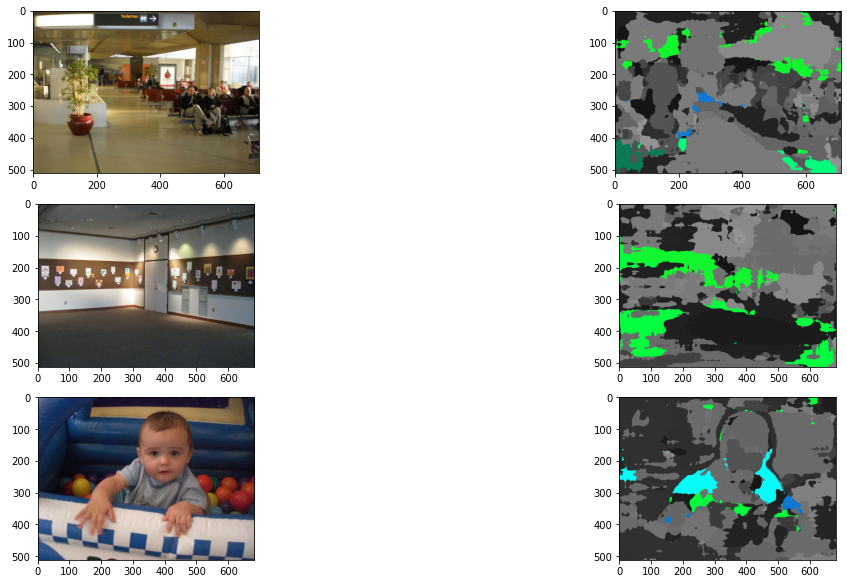

In [ ]:
image_name_list = ["ADE_train_00000002","ADE_train_00000003","ADE_train_00000005"]
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
new_FCN_model.to('cuda')
fig, axs = plt.subplots(len(image_name_list), 2, figsize=(16, 8), constrained_layout=True)

for i,image_name in enumerate(image_name_list):
  input_image = os.path.join(TARGET_GOOGLE_DRIVE_DIR,"images","training",f"{image_name}.jpg")
  input_image = Image.open(input_image).convert('RGB')

  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0)


  input_batch = input_batch.to('cuda')

  with torch.no_grad():
    output = new_FCN_model(input_batch)
    print(type(output))
    print(output['out'].shape)
    output = output['out'][0]
  output_predictions = output.argmax(0)

  palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
  colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
  colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
  r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
  r.putpalette(colors)
  axs[i,0].imshow(input_image)
  axs[i,1].imshow(r)

In [24]:
#retrain the model
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.CenterCrop(480)
])


In [25]:
trainset = ADE20KSegmentation(split='train', transform=image_transform)
validationset = ADE20KSegmentation(split='val', transform=image_transform)
testset = ADE20KSegmentation(split='test', transform=image_transform)

Found 20210 images in the folder /content/drive/MyDrive/6.869/ADEChallengeData2016
Found 2000 images in the folder /content/drive/MyDrive/6.869/ADEChallengeData2016
Found 2000 images in the folder /content/drive/MyDrive/6.869/ADEChallengeData2016


In [26]:
# Create Training Loader
train_dataloader = data.DataLoader(
    trainset, batch_size = 4, shuffle=True,
    num_workers=2)
validation_dataloader = data.DataLoader(
    validationset,batch_size = 4, shuffle=True,
    num_workers=2
)
test_dataloader = data.DataLoader(
    testset, batch_size = 4, shuffle=True,
    num_workers = 2
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([8, 3, 480, 480])
Labels batch shape: torch.Size([8, 480, 480])


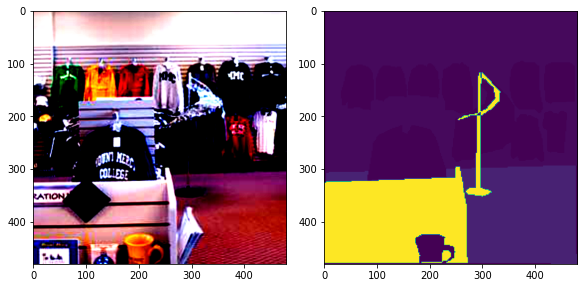

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
train_data= next(iter(train_dataloader))
print(f"Feature batch shape: {train_data[0].size()}")
print(f"Labels batch shape: {train_data[1].size()}")
train_image = torch.tensor(train_data[0][0, :, :, :]).permute(1,2,0)
axs[0].imshow(train_image)
semantic_image = train_data[1][0,:,:]
axs[1].imshow(semantic_image)

#Basic Helper Functions

In [27]:
def visualize_performance_on_sample_image(model,dataset = "training",index = 0):
  if dataset == "training":
    if index == 0:
      image_name_list = ["ADE_train_00000002","ADE_train_00000003","ADE_train_00000005"]
    else:
      image_name_list = ["ADE_train_00000009","ADE_train_00000007","ADE_train_00000008"]
  else:
    if index == 0:
      image_name_list = ["ADE_val_00000002","ADE_val_00000003","ADE_val_00000005"]
    else:
      image_name_list = ["ADE_val_00000009","ADE_val_00000007","ADE_val_00000008"]
  preprocess = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])
  model.to('cuda')
  fig, axs = plt.subplots(len(image_name_list), 2, figsize=(16, 8), constrained_layout=True)

  for i,image_name in enumerate(image_name_list):
    if dataset == "training":
      input_image = os.path.join(TARGET_GOOGLE_DRIVE_DIR,"images","training",f"{image_name}.jpg")
    else:
      input_image = os.path.join(TARGET_GOOGLE_DRIVE_DIR,"images","validation",f"{image_name}.jpg")
    input_image = Image.open(input_image).convert('RGB')

    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)


    input_batch = input_batch.to('cuda')

    with torch.no_grad():
      output = model(input_batch)
      print(type(output))
      print(output['out'].shape)
      output = output['out'][0]
    output_predictions = output.argmax(0)

    #palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    #colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
    #colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
    r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
    #r.putpalette(colors)
    axs[i,0].imshow(input_image)
    axs[i,1].imshow(r)

In [28]:
def one_hot_encoding(label,label_values = range(150)):
  semantic_map = []
  for i in label_values:
    class_map = (label == i)*1
    semantic_map.append(class_map)
  mask_coded = np.stack(semantic_map,axis = -1)
  mask_coded = torch.tensor(mask_coded)
  mask_coded = mask_coded.permute(0,3,1,2)
  return mask_coded

In [29]:
def IoU_compute(output,label,num_classes = 150):
  output = torch.argmax(output, dim=1).squeeze(1)
  output = output.view(-1)
  label = label.view(-1)

  iou_list = []
  present_iou_list = []

  for semantic_class in range(num_classes):
    output_inds = (output == semantic_class)
    label_inds = (label == semantic_class)
    if label_inds.long().sum().item() == 0:
      iou_now = float('nan')
    else:
      intersection_now = (output_inds[label_inds]).long().sum().item()
      union_now = label_inds.long().sum().item() + output_inds.long().sum().item() - intersection_now
      iou_now = float(intersection_now) / float(union_now)
      present_iou_list.append(iou_now)
    iou_list.append(iou_now)
    if len(present_iou_list) == 0:
      avg_iou = 0
    else:
      avg_iou = np.mean(present_iou_list)*100
  return avg_iou

In [30]:
optimizer = torch.optim.SGD(new_FCN_model.parameters(), lr=0.001, momentum=0.9)
loss_f = nn.CrossEntropyLoss()
def train_model(model,train_dataloader,validation_dataloader,optimizer,loss_f,num_epochs):
  since = time.time()
  train_loss = []
  running_loss = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch + 1, num_epochs))
    print('-' * 10)
    train_loss_per_100_itr = 0
    training_mean_iou_total = 0
    training_mean_iou_per_100_itr = 0

    for i in tqdm(range(2000)):
    #for i,input_pairs in enumerate(train_dataloader):
      input_pairs = next(iter(train_dataloader))
      train_data = input_pairs[0]
      semantic_label = input_pairs[1]
      train_data = train_data.to(device)
      semantic_data = one_hot_encoding(semantic_label)
      semantic_label = semantic_label.to(device)
      semantic_data = semantic_data.to(device)

      optimizer.zero_grad()
      output = model(train_data)['out']

      iou_per_batch = IoU_compute(output,semantic_label)
      training_mean_iou_total += iou_per_batch
      training_mean_iou_per_100_itr += iou_per_batch

      loss = loss_f(output,semantic_data.float())
      loss.backward()
      optimizer.step()

      count = i + 1
      if count % 100 == 0:
        print("avg train loss per 100 itr: ", train_loss_per_100_itr/100)
        print("avg train mean iou per 100 itr: ", training_mean_iou_per_100_itr/100)
        training_mean_iou_per_100_itr = 0
        train_loss_per_100_itr = 0
      elif i == 0:
        print("initial loss: ", loss.item())
      else:
        train_loss_per_100_itr += loss.item()
      

      running_loss += loss.item()

    epoch_loss = running_loss/2000
    mean_iou_per_epoch = training_mean_iou_per_100_itr/2000
    train_loss.append(epoch_loss)
    print("train loss per epoch: ", train_loss)
    print("train loss per epoch: ", mean_iou_per_epoch)

  return model,train_loss


In [31]:
def evaluate_model(model,loss_f,test_dataloader):
  total_test_loss = 0
  test_loss_itr = 0
  validation_mean_iou = 0
  mean_iou_per_100 = 0
  for i in tqdm(range(500)):
    test_pair = next(iter(test_dataloader))
    test_data = test_pair[0]
    semantic_label = test_pair[1]
    semantic_data = one_hot_encoding(semantic_label).float()
    test_data = test_data.to(device)
    semantic_data = semantic_data.to(device)
    semantic_label = semantic_label.to(device)
    count = i+1

    with torch.no_grad():
      output = model(test_data)['out']
      iou_per_batch = IoU_compute(output,semantic_label)
      validation_mean_iou += iou_per_batch
      mean_iou_per_100 += iou_per_batch
      test_loss = loss_f(output,semantic_data)
      total_test_loss += test_loss.item()
      test_loss_itr += test_loss.item()

      if i == 0:
        print("initial validation loss: ", test_loss.item())
        print("======")
        print("initial validation IOU: ", iou_per_batch)
      elif count % 100 == 0:
        print("validation loss per 100 itr", test_loss_itr/100)
        print("======")
        print("validation mean IOU per 100 itr: ", mean_iou_per_100/100)
        mean_iou_per_100 = 0
        test_loss_itr = 0

  avg_test_loss = total_test_loss/500
  avg_iou = validation_mean_iou/500
  print("final mean IOU: ", avg_iou)
  print("test loss: ", avg_test_loss)

  return avg_test_loss,avg_iou


#FCN

After training 2000 images

<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 711])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 683])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 683])


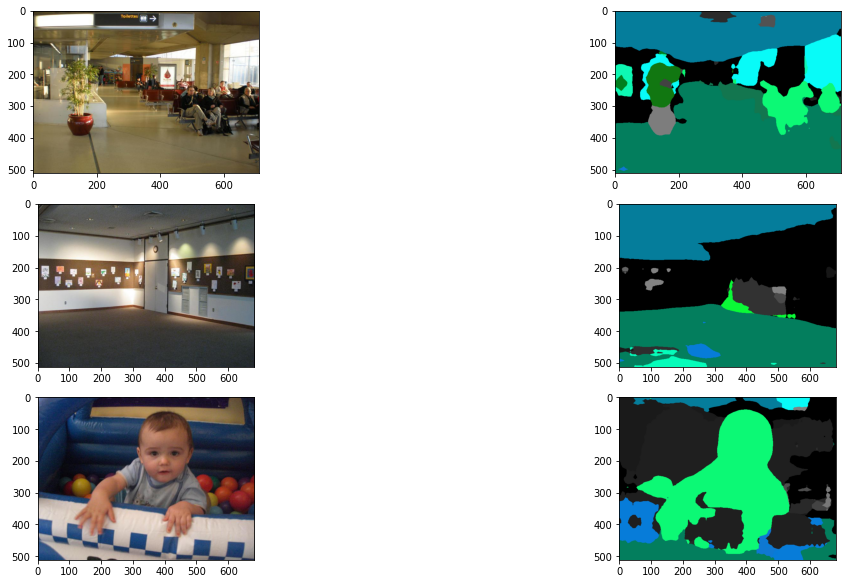

In [ ]:
image_name_list = ["ADE_train_00000002","ADE_train_00000003","ADE_train_00000005"]
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
new_FCN_model.to('cuda')
fig, axs = plt.subplots(len(image_name_list), 2, figsize=(16, 8), constrained_layout=True)

for i,image_name in enumerate(image_name_list):
  input_image = os.path.join(TARGET_GOOGLE_DRIVE_DIR,"images","training",f"{image_name}.jpg")
  input_image = Image.open(input_image).convert('RGB')

  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0)


  input_batch = input_batch.to('cuda')

  with torch.no_grad():
    output = new_FCN_model(input_batch)
    print(type(output))
    print(output['out'].shape)
    output = output['out'][0]
  output_predictions = output.argmax(0)

  palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
  colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
  colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
  r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
  r.putpalette(colors)
  axs[i,0].imshow(input_image)
  axs[i,1].imshow(r)

save current trained model

In [ ]:
model_name = "new_FCN"
path = '/content/drive/MyDrive/6.869/{model_name}'
torch.save(new_FCN_model.state_dict(), path)

train another epoch

In [ ]:
model_name = "new_FCN"
path = '/content/drive/MyDrive/6.869/{model_name}'
new_FCN_model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
train_dataloader = data.DataLoader(
    trainset, batch_size = 4, shuffle=True,
    num_workers=2)
validation_dataloader = data.DataLoader(
    validationset,batch_size = 4, shuffle=True,
    num_workers=2
)

In [ ]:
new_FCN_model.to(device)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [ ]:
#second time
#train another epoch
train_model(new_FCN_model,train_dataloader,validation_dataloader,optimizer,loss_f,1)

Epoch 1/1
----------


100%|██████████| 1000/1000 [1:18:10<00:00,  4.69s/it]


(FCN(
   (backbone): IntermediateLayerGetter(
     (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
     (layer1): Sequential(
       (0): Bottleneck(
         (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (relu): ReLU(inplace=True)
         (downs

<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 711])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 683])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 683])


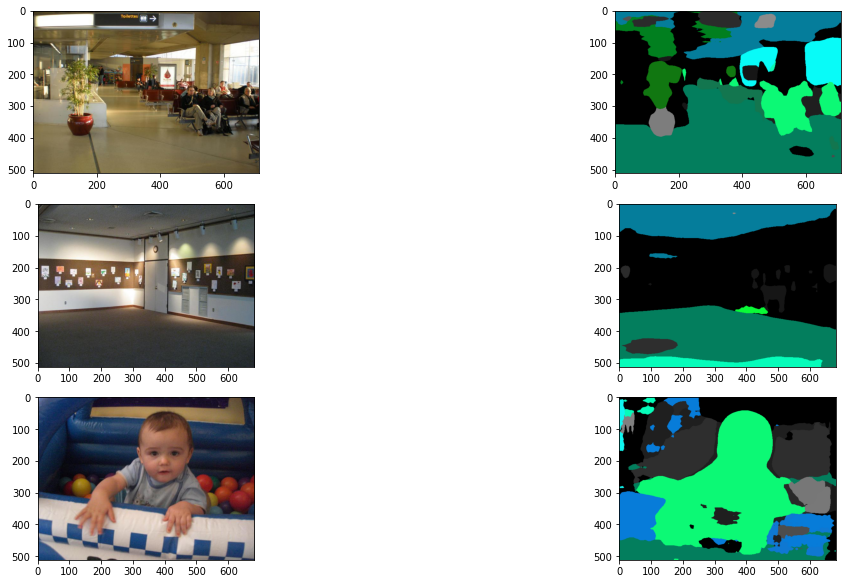

In [ ]:
visualize_performance_on_sample_image()

In [ ]:
model_name = "new_FCN2"
path = '/content/drive/MyDrive/6.869/{model_name}'
torch.save(new_FCN_model.state_dict(), path)

detection of wall, floor is getting better but human detection performance seems decay

In [ ]:
#third time
train_model(new_FCN_model,train_dataloader,validation_dataloader,optimizer,loss_f,1)

Epoch 1/1
----------


100%|██████████| 1000/1000 [1:08:08<00:00,  4.09s/it]


(FCN(
   (backbone): IntermediateLayerGetter(
     (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
     (layer1): Sequential(
       (0): Bottleneck(
         (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (relu): ReLU(inplace=True)
         (downs

<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 711])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 683])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 683])


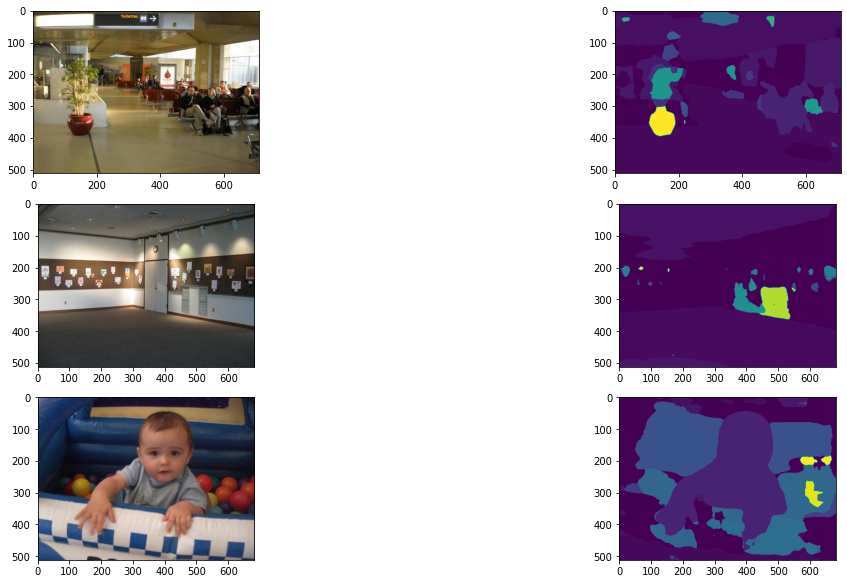

In [ ]:
visualize_performance_on_sample_image()

In [ ]:
model_name = "new_FCN3"
path = '/content/drive/MyDrive/6.869/{model_name}'
torch.save(new_FCN_model.state_dict(), path)

In [ ]:
model_name = "new_FCN3"
path = '/content/drive/MyDrive/6.869/{model_name}'
new_FCN_model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
new_FCN_model.to(device)
train_model(new_FCN_model,train_dataloader,validation_dataloader,optimizer,loss_f,1)

Epoch 1/1
----------


100%|██████████| 2000/2000 [2:47:30<00:00,  5.03s/it]


(FCN(
   (backbone): IntermediateLayerGetter(
     (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
     (layer1): Sequential(
       (0): Bottleneck(
         (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (relu): ReLU(inplace=True)
         (downs

<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 711])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 683])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 683])


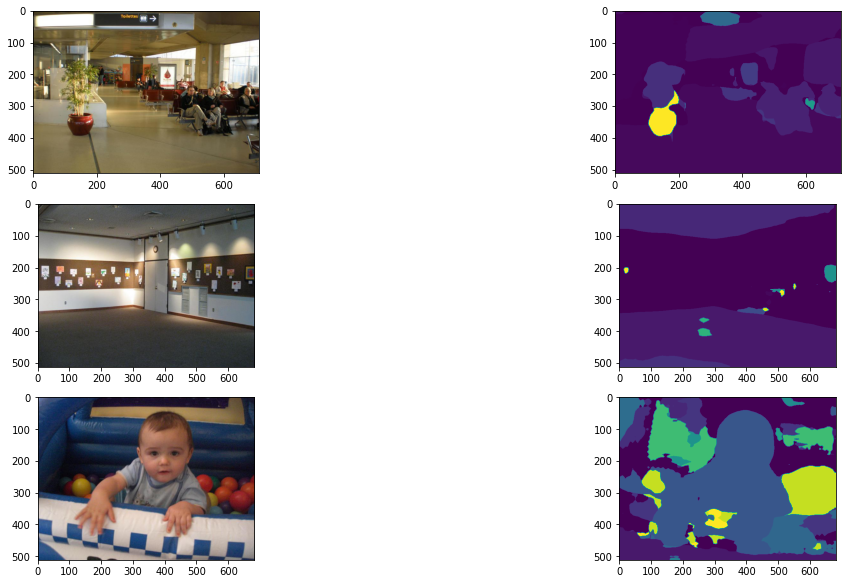

In [ ]:
visualize_performance_on_sample_image()

In [ ]:
model_name = "new_FCN4"
path = '/content/drive/MyDrive/6.869/{model_name}'
torch.save(new_FCN_model.state_dict(), path)

In [ ]:
model_name = "new_FCN4"
path = '/content/drive/MyDrive/6.869/{model_name}'
new_FCN_model.load_state_dict(torch.load(path))

<All keys matched successfully>

Epoch 1/2
----------


100%|██████████| 2000/2000 [3:52:16<00:00,  6.97s/it]


<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 711])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 683])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 683])


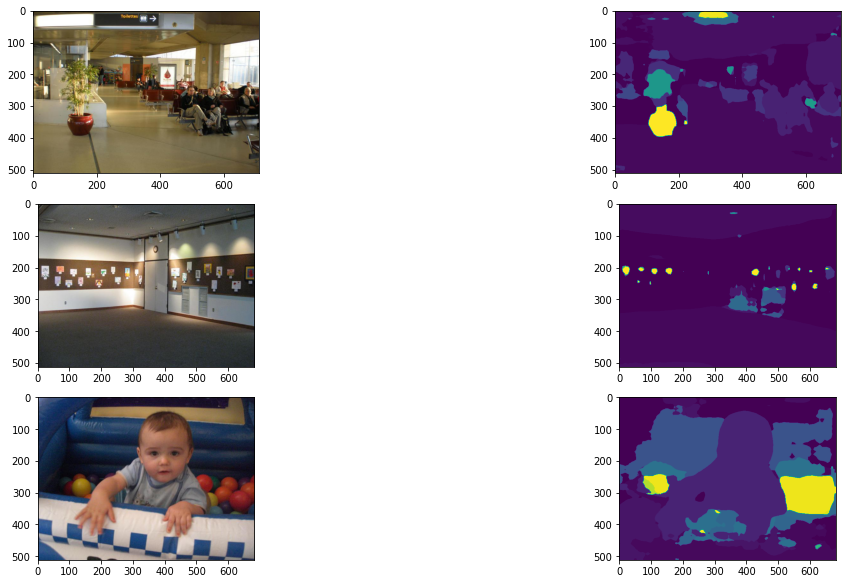

In [ ]:
new_FCN_model.to(device)
train_model(new_FCN_model,train_dataloader,validation_dataloader,optimizer,loss_f,2)
model_name_4 = "new_FCN5"
path = '/content/drive/MyDrive/6.869/{model_name_4}'
torch.save(new_FCN_model.state_dict(), path)
visualize_performance_on_sample_image()

In [ ]:
model_name_4 = "new_FCN5"
path = '/content/drive/MyDrive/6.869/{model_name_4}'
new_FCN_model.load_state_dict(torch.load(path))
new_FCN_model.to(device)
train_model(new_FCN_model,train_dataloader,validation_dataloader,optimizer,loss_f,1)

Epoch 1/1
----------


100%|██████████| 2000/2000 [3:49:08<00:00,  6.87s/it]


(FCN(
   (backbone): IntermediateLayerGetter(
     (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
     (layer1): Sequential(
       (0): Bottleneck(
         (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (relu): ReLU(inplace=True)
         (downs

<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 711])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 683])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 683])


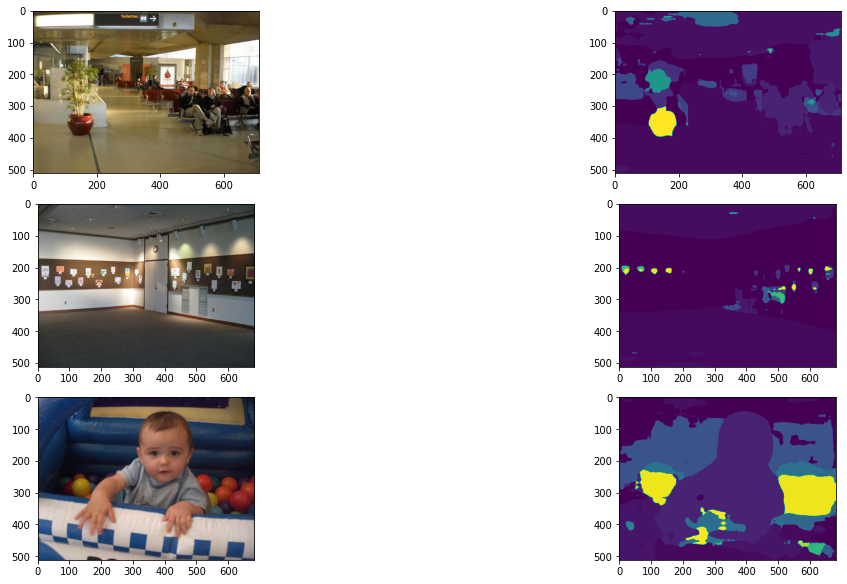

In [ ]:
visualize_performance_on_sample_image()

ground truth for another set of images

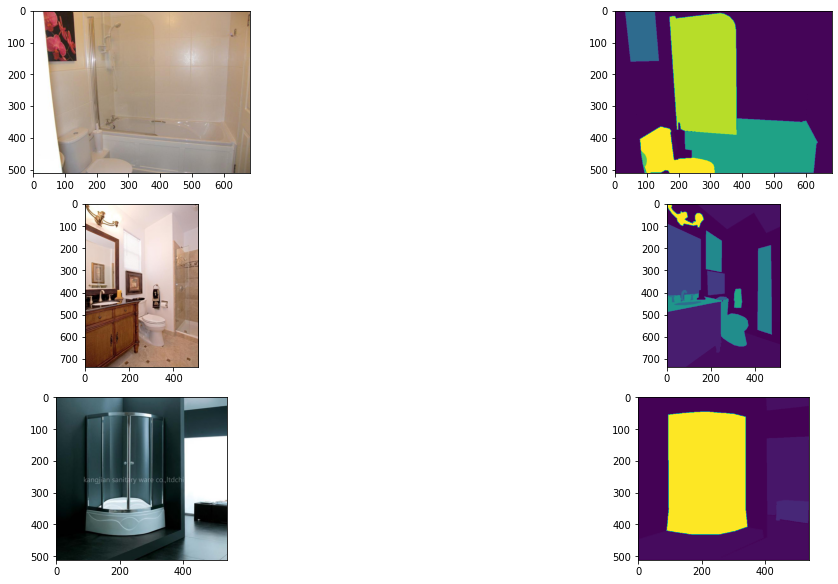

In [ ]:
image_name_list = ["ADE_train_00000009","ADE_train_00000007","ADE_train_00000008"]
fig, axs = plt.subplots(len(image_name_list), 2, figsize=(16, 8), constrained_layout=True)
for i,image_name in enumerate(image_name_list):
  original_image = os.path.join(TARGET_GOOGLE_DRIVE_DIR,"images","training",f"{image_name}.jpg")
  label_image = os.path.join(TARGET_GOOGLE_DRIVE_DIR, "annotations", "training", f"{image_name}.png")
  original_img = Image.open(original_image).convert('RGB')
  mask_img = Image.open(label_image)

  axs[i,0].imshow(original_img)
  axs[i,0].grid(False)

  label_image = np.asarray(mask_img)
  axs[i,1].imshow(label_image)
  axs[i,1].grid(False)

<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 683])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 735, 512])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 538])


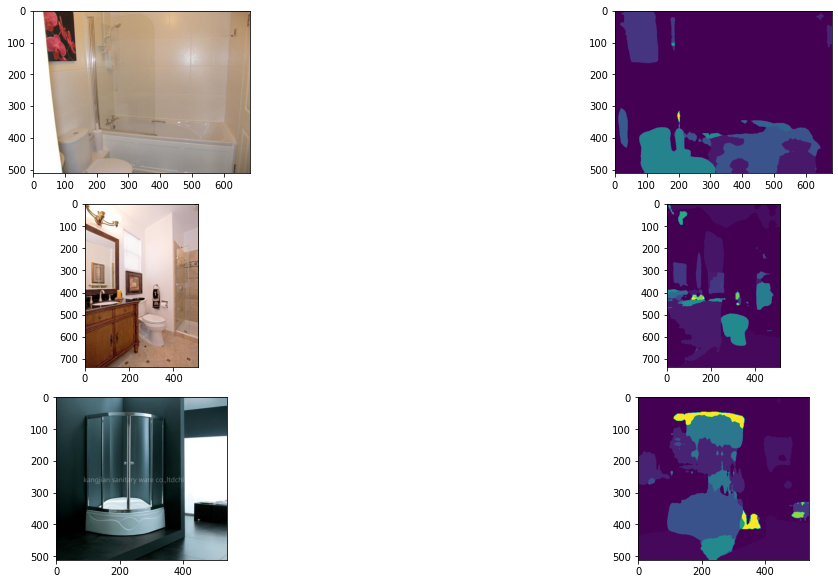

In [ ]:
visualize_performance_on_sample_image()

In [ ]:
model_name_5 = "new_FCN6"
path = '/content/drive/MyDrive/6.869/{model_name_5}'
torch.save(new_FCN_model.state_dict(), path)

Epoch 1/1
----------


100%|██████████| 2000/2000 [3:49:33<00:00,  6.89s/it]


<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 683])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 735, 512])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 538])


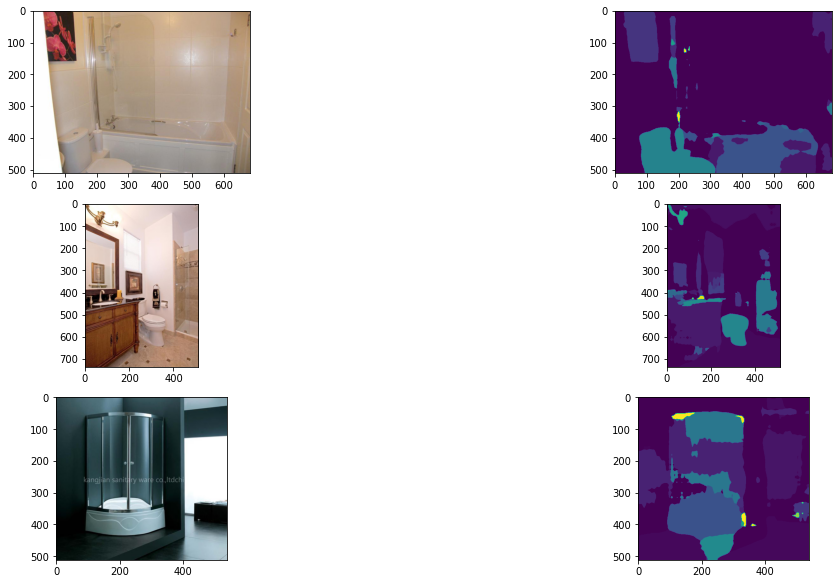

In [ ]:
train_model(new_FCN_model,train_dataloader,validation_dataloader,optimizer,loss_f,1)
model_name_6 = "new_FCN7"
path = '/content/drive/MyDrive/6.869/{model_name_6}'
torch.save(new_FCN_model.state_dict(), path)
visualize_performance_on_sample_image()

In [ ]:
model_name_6 = "new_FCN7"
path = '/content/drive/MyDrive/6.869/{model_name_6}'
torch.save(new_FCN_model.state_dict(), path)

<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 711])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 683])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 683])


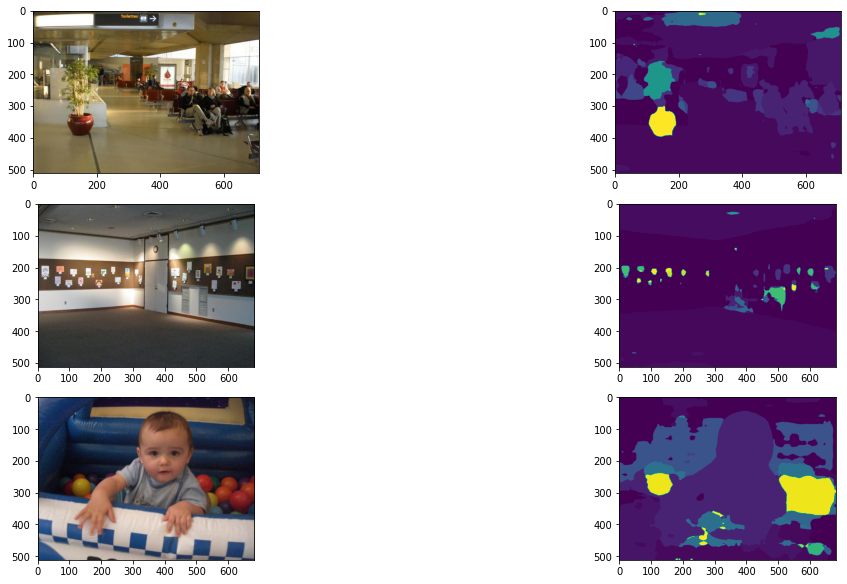

In [ ]:
visualize_performance_on_sample_image()

In [ ]:
model_name_6 = "new_FCN7"
path = '/content/drive/MyDrive/6.869/{model_name_6}'
new_FCN_model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
new_FCN_model.to(device)
train_model(new_FCN_model,train_dataloader,validation_dataloader,optimizer,loss_f,2)

Epoch 1/2
----------


  0%|          | 1/2000 [00:10<5:42:57, 10.29s/it]

initial loss:  2.4858617782592773


  5%|▌         | 100/2000 [15:45<4:57:45,  9.40s/it]

avg train loss per 100 itr:  1.640281075835228


 10%|█         | 200/2000 [30:54<4:18:38,  8.62s/it]

avg train loss per 100 itr:  1.427160902619362


 15%|█▌        | 300/2000 [45:32<4:09:06,  8.79s/it]

avg train loss per 100 itr:  1.4659760764241219


 20%|██        | 400/2000 [1:00:59<4:06:58,  9.26s/it]

avg train loss per 100 itr:  1.4253207194805144


 25%|██▌       | 500/2000 [1:15:31<3:28:57,  8.36s/it]

avg train loss per 100 itr:  1.4536524564027786


 30%|███       | 600/2000 [1:29:13<3:10:12,  8.15s/it]

avg train loss per 100 itr:  1.3644347023963928


 35%|███▌      | 700/2000 [1:42:21<3:01:40,  8.38s/it]

avg train loss per 100 itr:  1.3251206147670747


 40%|████      | 800/2000 [1:55:07<2:33:01,  7.65s/it]

avg train loss per 100 itr:  1.3207399180531503


 45%|████▌     | 900/2000 [2:07:32<2:11:40,  7.18s/it]

avg train loss per 100 itr:  1.3656418132781982


 50%|█████     | 1000/2000 [2:19:42<1:53:54,  6.83s/it]

avg train loss per 100 itr:  1.2894918847084045


 55%|█████▌    | 1100/2000 [2:31:49<1:46:37,  7.11s/it]

avg train loss per 100 itr:  1.3899381572008134


 60%|██████    | 1200/2000 [2:43:36<1:41:12,  7.59s/it]

avg train loss per 100 itr:  1.370099083185196


 65%|██████▌   | 1300/2000 [2:55:03<1:16:28,  6.56s/it]

avg train loss per 100 itr:  1.3543600499629975


 70%|███████   | 1400/2000 [3:06:22<1:08:56,  6.89s/it]

avg train loss per 100 itr:  1.322773500829935


 75%|███████▌  | 1500/2000 [3:17:25<56:19,  6.76s/it]

avg train loss per 100 itr:  1.3639202105998993


 80%|████████  | 1600/2000 [3:28:18<40:05,  6.01s/it]

avg train loss per 100 itr:  1.2751064431667327


 85%|████████▌ | 1700/2000 [3:38:28<29:49,  5.96s/it]

avg train loss per 100 itr:  1.3620604208111764


 90%|█████████ | 1800/2000 [3:48:36<20:47,  6.24s/it]

avg train loss per 100 itr:  1.356206045150757


 95%|█████████▌| 1900/2000 [3:58:29<09:53,  5.94s/it]

avg train loss per 100 itr:  1.372569797039032


100%|██████████| 2000/2000 [4:08:21<00:00,  7.45s/it]


avg train loss per 100 itr:  1.3645000386238098
train loss per epoch:  [0.13806605379381492]
Epoch 2/2
----------


  0%|          | 1/2000 [00:04<2:43:16,  4.90s/it]

initial loss:  1.815060019493103


  5%|▌         | 100/2000 [09:49<3:21:30,  6.36s/it]

avg train loss per 100 itr:  1.387349582016468


 10%|█         | 200/2000 [19:15<2:39:00,  5.30s/it]

avg train loss per 100 itr:  1.3077619278430939


 15%|█▌        | 300/2000 [28:35<2:27:50,  5.22s/it]

avg train loss per 100 itr:  1.306030992269516


 20%|██        | 400/2000 [37:47<2:25:44,  5.47s/it]

avg train loss per 100 itr:  1.2843180751800538


 25%|██▌       | 500/2000 [46:52<2:19:36,  5.58s/it]

avg train loss per 100 itr:  1.3398887476325034


 30%|███       | 600/2000 [55:53<2:12:15,  5.67s/it]

avg train loss per 100 itr:  1.238600174188614


 35%|███▌      | 700/2000 [1:04:31<1:59:14,  5.50s/it]

avg train loss per 100 itr:  1.1937921464443206


 40%|████      | 800/2000 [1:13:01<1:40:27,  5.02s/it]

avg train loss per 100 itr:  1.285653432905674


 45%|████▌     | 900/2000 [1:21:50<1:31:32,  4.99s/it]

avg train loss per 100 itr:  1.3133240535855293


 50%|█████     | 1000/2000 [1:30:34<1:26:50,  5.21s/it]

avg train loss per 100 itr:  1.2532143133878708


 55%|█████▌    | 1100/2000 [1:39:02<1:16:15,  5.08s/it]

avg train loss per 100 itr:  1.2893126836419107


 60%|██████    | 1200/2000 [1:47:24<1:04:38,  4.85s/it]

avg train loss per 100 itr:  1.3081787520647048


 65%|██████▌   | 1300/2000 [1:55:56<1:00:55,  5.22s/it]

avg train loss per 100 itr:  1.2056489104032517


 70%|███████   | 1400/2000 [2:04:14<48:25,  4.84s/it]

avg train loss per 100 itr:  1.286213830113411


 75%|███████▌  | 1500/2000 [2:12:25<41:05,  4.93s/it]

avg train loss per 100 itr:  1.2316606616973877


 80%|████████  | 1600/2000 [2:20:33<30:52,  4.63s/it]

avg train loss per 100 itr:  1.2016162231564522


 85%|████████▌ | 1700/2000 [2:28:21<23:40,  4.74s/it]

avg train loss per 100 itr:  1.3113000819087028


 90%|█████████ | 1800/2000 [2:36:13<16:04,  4.82s/it]

avg train loss per 100 itr:  1.2764734175801278


 95%|█████████▌| 1900/2000 [2:44:03<07:50,  4.70s/it]

avg train loss per 100 itr:  1.1986087214946748


100%|██████████| 2000/2000 [2:51:48<00:00,  5.15s/it]

avg train loss per 100 itr:  1.2112104859948158
train loss per epoch:  [0.13806605379381492, 0.2652873462560978]


(FCN(
   (backbone): IntermediateLayerGetter(
     (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
     (layer1): Sequential(
       (0): Bottleneck(
         (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (relu): ReLU(inplace=True)
         (downs

<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 711])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 683])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 683])


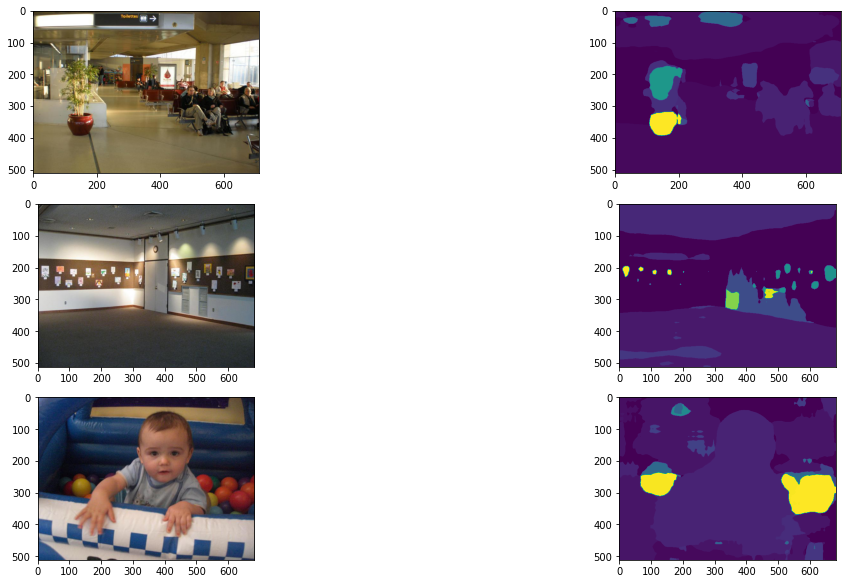

In [ ]:
model_name_7 = "new_FCN8"
path = '/content/drive/MyDrive/6.869/{model_name_7}'
torch.save(new_FCN_model.state_dict(), path)
visualize_performance_on_sample_image()

<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 683])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 735, 512])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 538])


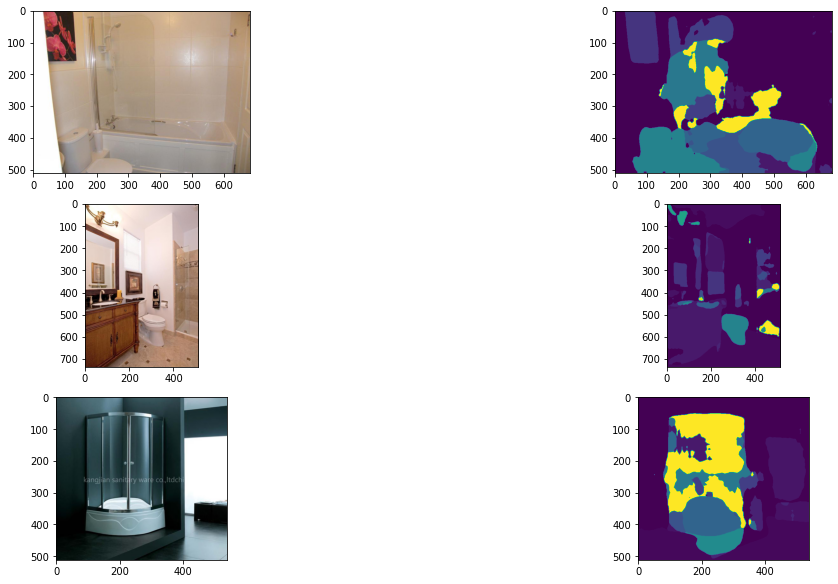

In [ ]:
visualize_performance_on_sample_image(1)

In [ ]:
model_name_7 = "new_FCN8"
path = '/content/drive/MyDrive/6.869/{model_name_7}'
new_FCN_model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
new_FCN_model.to(device)
train_model(new_FCN_model,train_dataloader,validation_dataloader,optimizer,loss_f,2)

Epoch 1/2
----------


  0%|          | 1/2000 [00:11<6:34:25, 11.84s/it]

initial loss:  0.8019200563430786


  5%|▌         | 100/2000 [17:31<5:20:24, 10.12s/it]

avg train loss per 100 itr:  1.2644070547819137


 10%|█         | 200/2000 [34:14<5:04:11, 10.14s/it]

avg train loss per 100 itr:  1.231687566936016


 15%|█▌        | 300/2000 [50:32<4:21:11,  9.22s/it]

avg train loss per 100 itr:  1.2247435900568961


 20%|██        | 400/2000 [1:06:15<3:54:03,  8.78s/it]

avg train loss per 100 itr:  1.2948835644125938


 25%|██▌       | 500/2000 [1:21:45<3:56:04,  9.44s/it]

avg train loss per 100 itr:  1.249727104306221


 30%|███       | 600/2000 [1:36:29<3:16:26,  8.42s/it]

avg train loss per 100 itr:  1.2384826588630675


 35%|███▌      | 700/2000 [1:50:49<3:13:07,  8.91s/it]

avg train loss per 100 itr:  1.2151866206526756


 40%|████      | 800/2000 [2:04:35<2:37:29,  7.87s/it]

avg train loss per 100 itr:  1.2178124141693116


 45%|████▌     | 900/2000 [2:18:55<2:25:47,  7.95s/it]

avg train loss per 100 itr:  1.2529662540555


 50%|█████     | 1000/2000 [2:32:04<2:03:33,  7.41s/it]

avg train loss per 100 itr:  1.2052869087457656


 55%|█████▌    | 1100/2000 [2:45:03<1:46:23,  7.09s/it]

avg train loss per 100 itr:  1.2232574281096458


 60%|██████    | 1200/2000 [2:57:42<1:37:49,  7.34s/it]

avg train loss per 100 itr:  1.2672620597481727


 65%|██████▌   | 1300/2000 [3:09:56<1:25:54,  7.36s/it]

avg train loss per 100 itr:  1.2211630856990814


 70%|███████   | 1400/2000 [3:21:31<1:03:03,  6.31s/it]

avg train loss per 100 itr:  1.2233872476220131


 75%|███████▌  | 1500/2000 [3:33:21<57:45,  6.93s/it]

avg train loss per 100 itr:  1.2640443634986878


 80%|████████  | 1600/2000 [3:44:47<45:25,  6.81s/it]

avg train loss per 100 itr:  1.2296932861208916


 85%|████████▌ | 1700/2000 [3:55:42<31:49,  6.37s/it]

avg train loss per 100 itr:  1.1545374202728271


 90%|█████████ | 1800/2000 [4:06:40<24:11,  7.26s/it]

avg train loss per 100 itr:  1.1381137758493423


 95%|█████████▌| 1900/2000 [4:17:25<11:00,  6.60s/it]

avg train loss per 100 itr:  1.1330946797132493


100%|██████████| 2000/2000 [4:28:13<00:00,  8.05s/it]


avg train loss per 100 itr:  1.1637614521384239
train loss per epoch:  [0.12203392462527499]
Epoch 2/2
----------


  0%|          | 1/2000 [00:05<3:19:05,  5.98s/it]

initial loss:  1.3509905338287354


  5%|▌         | 100/2000 [10:29<3:33:22,  6.74s/it]

avg train loss per 100 itr:  1.153409315943718


 10%|█         | 200/2000 [20:51<2:54:35,  5.82s/it]

avg train loss per 100 itr:  1.273042271733284


 15%|█▌        | 300/2000 [30:58<2:55:04,  6.18s/it]

avg train loss per 100 itr:  1.1112618613243104


 20%|██        | 400/2000 [41:00<2:46:57,  6.26s/it]

avg train loss per 100 itr:  1.262265439927578


 25%|██▌       | 500/2000 [51:18<2:23:52,  5.76s/it]

avg train loss per 100 itr:  1.270413083434105


 30%|███       | 600/2000 [1:01:14<2:12:34,  5.68s/it]

avg train loss per 100 itr:  1.2118461453914642


 35%|███▌      | 700/2000 [1:10:59<2:09:49,  5.99s/it]

avg train loss per 100 itr:  1.2404411485791207


 40%|████      | 800/2000 [1:20:36<1:53:20,  5.67s/it]

avg train loss per 100 itr:  1.105905621945858


 45%|████▌     | 900/2000 [1:29:54<1:36:12,  5.25s/it]

avg train loss per 100 itr:  1.2677850231528283


 50%|█████     | 1000/2000 [1:39:17<1:27:31,  5.25s/it]

avg train loss per 100 itr:  1.173318468630314


 55%|█████▌    | 1100/2000 [1:48:17<1:31:47,  6.12s/it]

avg train loss per 100 itr:  1.118440950512886


 60%|██████    | 1200/2000 [1:57:10<1:12:07,  5.41s/it]

avg train loss per 100 itr:  1.195074811577797


 65%|██████▌   | 1300/2000 [2:06:01<1:02:55,  5.39s/it]

avg train loss per 100 itr:  1.090587234199047


 70%|███████   | 1400/2000 [2:14:45<52:05,  5.21s/it]

avg train loss per 100 itr:  1.1742564019560815


 75%|███████▌  | 1500/2000 [2:23:29<45:11,  5.42s/it]

avg train loss per 100 itr:  1.0530936655402183


 80%|████████  | 1600/2000 [2:32:09<31:19,  4.70s/it]

avg train loss per 100 itr:  1.1787710055708884


 85%|████████▌ | 1700/2000 [2:40:46<26:33,  5.31s/it]

avg train loss per 100 itr:  1.1873050972819328


 90%|█████████ | 1800/2000 [2:49:07<16:25,  4.93s/it]

avg train loss per 100 itr:  1.231510920524597


 95%|█████████▌| 1900/2000 [2:57:45<08:25,  5.06s/it]

avg train loss per 100 itr:  1.140756680071354


100%|██████████| 2000/2000 [3:06:08<00:00,  5.58s/it]

avg train loss per 100 itr:  1.1727114683389663
train loss per epoch:  [0.12203392462527499, 0.24029843041443813]


(FCN(
   (backbone): IntermediateLayerGetter(
     (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
     (layer1): Sequential(
       (0): Bottleneck(
         (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (relu): ReLU(inplace=True)
         (downs

In [ ]:
#model_name_8 = "new_FCN9"
#path = '/content/drive/MyDrive/6.869/{model_name_8}'
#torch.save(new_FCN_model.state_dict(), path)

In [ ]:
model_name_8 = "new_FCN9"
path = '/content/drive/MyDrive/6.869/{model_name_8}'
new_FCN_model.load_state_dict(torch.load(path))
new_FCN_model.to(device)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

model 9

In [ ]:
evaluate_model(new_FCN_model,loss_f,validation_dataloader)

  0%|          | 1/500 [00:05<44:54,  5.40s/it]

initial validation loss:  2.7477567195892334
initial validation IOU:  24.7365143542991


 20%|██        | 100/500 [08:18<32:16,  4.84s/it]

validation loss per 100 itr 2.8000721597671507
validation mean IOU per 100 itr:  22.820753543172497


 40%|████      | 200/500 [16:08<22:28,  4.49s/it]

validation loss per 100 itr 2.8180356645584106
validation mean IOU per 100 itr:  23.85813523894093


 60%|██████    | 300/500 [23:42<15:01,  4.51s/it]

validation loss per 100 itr 2.8081648910045622
validation mean IOU per 100 itr:  23.398802645528193


 80%|████████  | 400/500 [31:00<07:08,  4.29s/it]

validation loss per 100 itr 2.852913868427277
validation mean IOU per 100 itr:  23.891154178580667


100%|██████████| 500/500 [38:12<00:00,  4.58s/it]

validation loss per 100 itr 2.8439456629753113
validation mean IOU per 100 itr:  23.047775738268875
final mean IOU:  23.403324268898224
test loss:  0.06988190127032515


(0.06988190127032515, 23.403324268898224)

mean iou of new_FCN_model(version 9) is 23.403

In [ ]:
train_model(new_FCN_model,train_dataloader,validation_dataloader,optimizer,loss_f,1)

Epoch 1/1
----------


  0%|          | 1/2000 [00:15<8:41:13, 15.64s/it]

initial loss:  2.9087681770324707


  5%|▌         | 100/2000 [25:48<8:18:02, 15.73s/it]

avg train loss per 100 itr:  2.235879418849945
avg train mean iou per 100 itr:  17.338319819517526


 10%|█         | 200/2000 [50:11<6:51:50, 13.73s/it]

avg train loss per 100 itr:  1.8832616049051285
avg train mean iou per 100 itr:  16.139780665257035


 15%|█▌        | 300/2000 [1:13:52<6:57:19, 14.73s/it]

avg train loss per 100 itr:  1.8374306082725524
avg train mean iou per 100 itr:  17.308500091661998


 20%|██        | 400/2000 [1:37:02<6:21:32, 14.31s/it]

avg train loss per 100 itr:  1.8543563866615296
avg train mean iou per 100 itr:  18.298223425827047


 25%|██▌       | 500/2000 [1:59:03<5:28:41, 13.15s/it]

avg train loss per 100 itr:  1.72670485496521
avg train mean iou per 100 itr:  18.621150081112507


 30%|███       | 600/2000 [2:20:22<5:12:49, 13.41s/it]

avg train loss per 100 itr:  1.7709963309764862
avg train mean iou per 100 itr:  20.62389866878641


 35%|███▌      | 700/2000 [2:41:07<4:29:29, 12.44s/it]

avg train loss per 100 itr:  1.6708096635341645
avg train mean iou per 100 itr:  20.164043640376814


 40%|████      | 800/2000 [3:01:04<3:48:47, 11.44s/it]

avg train loss per 100 itr:  1.7556779015064239
avg train mean iou per 100 itr:  21.081293811331367


 45%|████▌     | 900/2000 [3:20:20<3:04:07, 10.04s/it]

avg train loss per 100 itr:  1.6090313929319382
avg train mean iou per 100 itr:  21.60340401422577


 50%|█████     | 1000/2000 [3:39:11<3:00:23, 10.82s/it]

avg train loss per 100 itr:  1.6174495023489
avg train mean iou per 100 itr:  21.44509525957641


 55%|█████▌    | 1100/2000 [3:57:28<2:41:23, 10.76s/it]

avg train loss per 100 itr:  1.6149900019168855
avg train mean iou per 100 itr:  22.73453767396525


 60%|██████    | 1200/2000 [4:15:58<2:28:21, 11.13s/it]

avg train loss per 100 itr:  1.550461533665657
avg train mean iou per 100 itr:  22.48339545825313


 65%|██████▌   | 1300/2000 [4:33:12<1:48:54,  9.33s/it]

avg train loss per 100 itr:  1.5786309850215912
avg train mean iou per 100 itr:  23.985525508651754


 70%|███████   | 1400/2000 [4:50:20<1:33:27,  9.35s/it]

avg train loss per 100 itr:  1.501789227426052
avg train mean iou per 100 itr:  23.890298340629283


 75%|███████▌  | 1500/2000 [5:07:05<1:36:52, 11.62s/it]

avg train loss per 100 itr:  1.5393858736753463
avg train mean iou per 100 itr:  23.81595203178611


 80%|████████  | 1600/2000 [5:23:21<1:03:46,  9.57s/it]

avg train loss per 100 itr:  1.50928168207407
avg train mean iou per 100 itr:  24.08550818537242


 85%|████████▌ | 1700/2000 [5:37:30<42:22,  8.47s/it]

avg train loss per 100 itr:  1.512802917957306
avg train mean iou per 100 itr:  24.466005325512942


 90%|█████████ | 1800/2000 [5:51:38<28:53,  8.67s/it]

avg train loss per 100 itr:  1.4725287824869155
avg train mean iou per 100 itr:  24.978430034486593


 95%|█████████▌| 1900/2000 [6:04:26<11:03,  6.63s/it]

avg train loss per 100 itr:  1.469312914609909
avg train mean iou per 100 itr:  24.85996959619055


100%|██████████| 2000/2000 [6:17:19<00:00, 11.32s/it]

avg train loss per 100 itr:  1.4424557906389237
avg train mean iou per 100 itr:  24.431768990996638
train loss per epoch:  [1.6745659737288952]
train loss per epoch:  0.0


(FCN(
   (backbone): IntermediateLayerGetter(
     (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
     (layer1): Sequential(
       (0): Bottleneck(
         (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (relu): ReLU(inplace=True)
         (downs

In [ ]:
model_name_9 = "new_FCN10"
path = '/content/drive/MyDrive/6.869/{model_name_9}'
torch.save(new_FCN_model.state_dict(), path)

<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 683])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 735, 512])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 538])


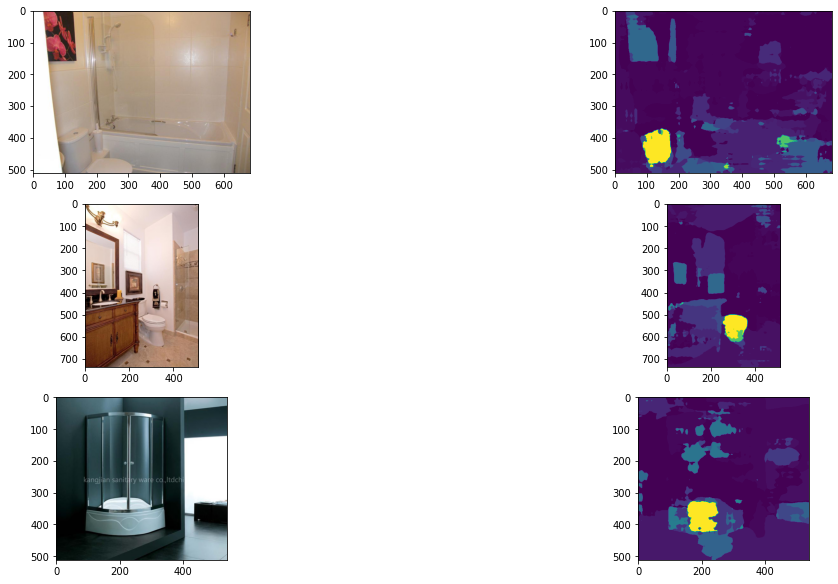

In [ ]:
visualize_performance_on_sample_image(1)

<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 711])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 683])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 683])


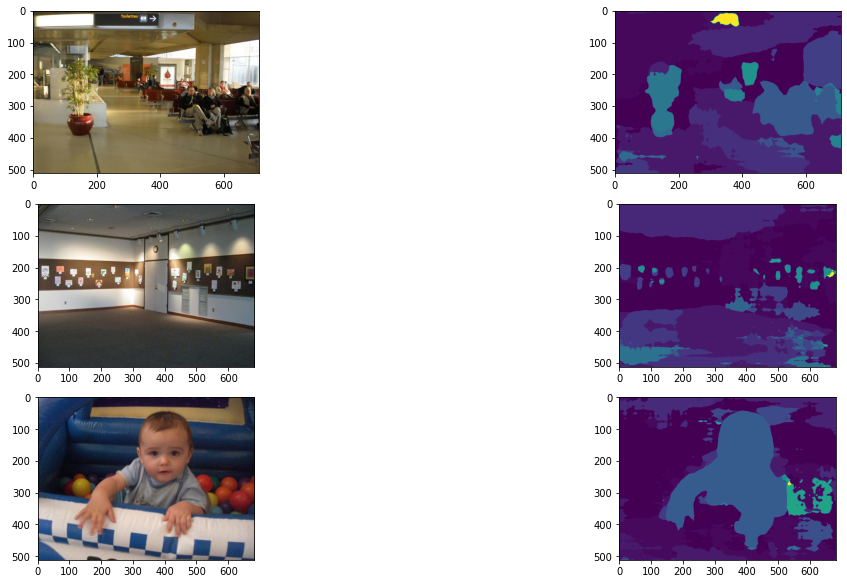

In [ ]:
visualize_performance_on_sample_image(0)

In [ ]:
evaluate_model(new_FCN_model,loss_f,validation_dataloader)

  0%|          | 1/500 [00:04<38:06,  4.58s/it]

initial validation loss:  1.9478707313537598
initial validation IOU:  20.241642211283462


 20%|██        | 100/500 [07:05<27:43,  4.16s/it]

validation loss per 100 itr 1.3965248566865922
validation mean IOU per 100 itr:  25.895892571592935


 40%|████      | 200/500 [14:02<20:46,  4.16s/it]

validation loss per 100 itr 1.3718075081706047
validation mean IOU per 100 itr:  27.483739322376863


 60%|██████    | 300/500 [20:57<13:57,  4.19s/it]

validation loss per 100 itr 1.4123636871576308
validation mean IOU per 100 itr:  27.417914895116557


 80%|████████  | 400/500 [27:50<06:51,  4.12s/it]

validation loss per 100 itr 1.3873967617750167
validation mean IOU per 100 itr:  28.018760671777407


100%|██████████| 500/500 [34:44<00:00,  4.17s/it]

validation loss per 100 itr 1.4376540172100067
validation mean IOU per 100 itr:  26.49069526047504
final mean IOU:  27.061400544267773
test loss:  0.03466475423552623


(0.03466475423552623, 27.061400544267773)

evaluate on the previous model 6

In [ ]:
evaluate_model(new_FCN_model,loss_f,validation_dataloader)

  0%|          | 1/500 [00:10<1:26:54, 10.45s/it]

initial validation loss:  3.1418988704681396
initial validation IOU:  30.27737758900355


 20%|██        | 100/500 [13:39<48:25,  7.26s/it]

validation loss per 100 itr 3.2397284746170043
validation mean IOU per 100 itr:  27.259127855432013


 40%|████      | 200/500 [23:46<25:21,  5.07s/it]

validation loss per 100 itr 3.249953076839447
validation mean IOU per 100 itr:  27.125400084173148


 60%|██████    | 300/500 [32:13<14:42,  4.41s/it]

validation loss per 100 itr 3.2095892667770385
validation mean IOU per 100 itr:  27.509440913741265


 80%|████████  | 400/500 [39:48<07:30,  4.50s/it]

validation loss per 100 itr 3.265623755455017
validation mean IOU per 100 itr:  26.752751489715603


100%|██████████| 500/500 [46:40<00:00,  5.60s/it]

validation loss per 100 itr 3.2562394189834594
validation mean IOU per 100 itr:  27.86147423912557
final mean IOU:  27.301638916437486
test loss:  0.0802629094145075


(0.0802629094145075, 27.301638916437486)

version 6 has 27.3 iou, which is the best among so-far trained model

#weird shit:trying to recover from version 6

<class 'collections.OrderedDict'>
torch.Size([1, 150, 364, 500])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 300, 400])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 300, 400])


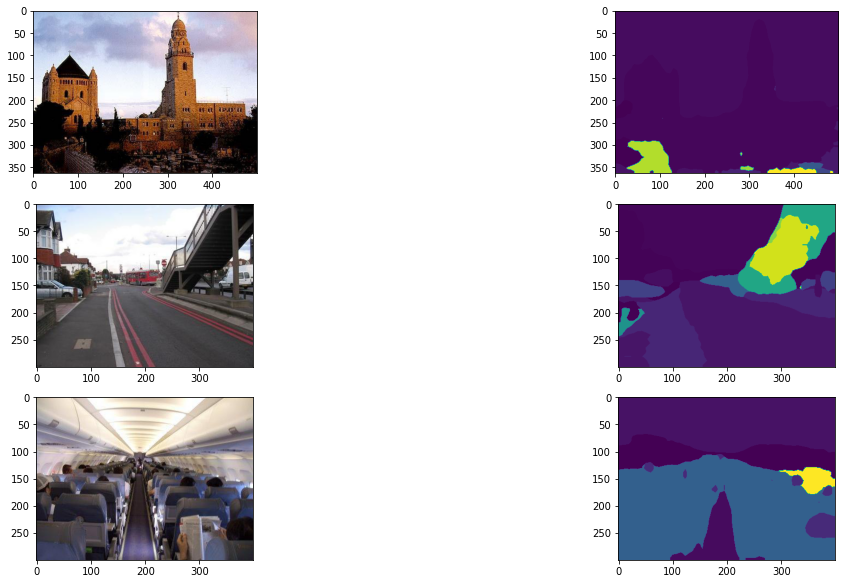

In [73]:
model_name_6= "new_FCN7"
path = '/content/drive/MyDrive/6.869/{model_name_6}'
new_FCN_model.load_state_dict(torch.load(path))
new_FCN_model.eval()
visualize_performance_on_sample_image(new_FCN_model,"validation",0)

In [ ]:
model_name_6 = "new_FCN_7"
path = '/content/drive/MyDrive/6.869/{model_name_6}'
new_FCN_model.load_state_dict(torch.load(path))

<All keys matched successfully>

<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 711])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 683])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 683])


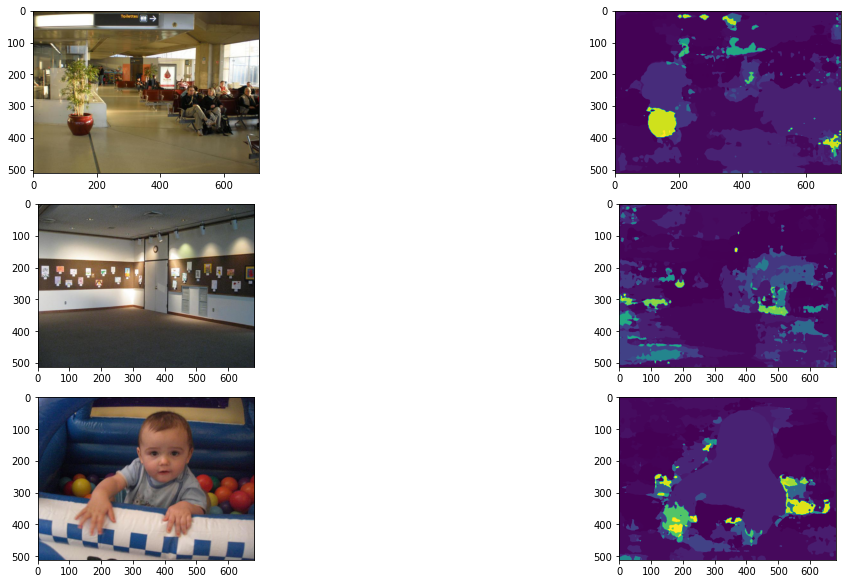

In [ ]:
new_FCN_model.to(device)
visualize_performance_on_sample_image(0)

In [ ]:
train_model(new_FCN_model,train_dataloader,validation_dataloader,optimizer,loss_f,1)
visualize_performance_on_sample_image(0)

Epoch 1/1
----------


  0%|          | 1/2000 [00:10<5:38:49, 10.17s/it]

initial loss:  3.3813064098358154


  5%|▌         | 100/2000 [15:02<4:38:30,  8.80s/it]

avg train loss per 100 itr:  2.8783391535282137
avg train mean iou per 100 itr:  20.38829049164831


 10%|█         | 200/2000 [30:12<4:34:30,  9.15s/it]

avg train loss per 100 itr:  2.6715573441982268
avg train mean iou per 100 itr:  19.8630959585764


 15%|█▌        | 300/2000 [44:25<3:58:11,  8.41s/it]

avg train loss per 100 itr:  2.412938537597656
avg train mean iou per 100 itr:  19.99205563909269


 20%|██        | 400/2000 [58:07<3:52:34,  8.72s/it]

avg train loss per 100 itr:  2.4783291804790495
avg train mean iou per 100 itr:  18.65795859766186


 25%|██▌       | 500/2000 [1:11:24<2:57:18,  7.09s/it]

avg train loss per 100 itr:  2.421583282351494
avg train mean iou per 100 itr:  18.596258818448


 30%|███       | 600/2000 [1:24:02<2:39:35,  6.84s/it]

avg train loss per 100 itr:  2.2256548261642455
avg train mean iou per 100 itr:  21.154512325127484


 35%|███▌      | 700/2000 [1:36:33<2:51:04,  7.90s/it]

avg train loss per 100 itr:  2.2110357272624968
avg train mean iou per 100 itr:  21.125531341872737


 40%|████      | 800/2000 [1:48:32<2:23:49,  7.19s/it]

avg train loss per 100 itr:  2.312454165220261
avg train mean iou per 100 itr:  20.142634898263335


 45%|████▌     | 900/2000 [2:00:01<1:59:58,  6.54s/it]

avg train loss per 100 itr:  2.194178758263588
avg train mean iou per 100 itr:  20.821817907041012


 50%|█████     | 1000/2000 [2:11:31<1:59:37,  7.18s/it]

avg train loss per 100 itr:  2.0950277984142303
avg train mean iou per 100 itr:  21.472889091193778


 55%|█████▌    | 1100/2000 [2:22:41<1:33:55,  6.26s/it]

avg train loss per 100 itr:  2.153968970179558
avg train mean iou per 100 itr:  20.979778692265374


 60%|██████    | 1200/2000 [2:33:37<1:28:42,  6.65s/it]

avg train loss per 100 itr:  2.054829181432724
avg train mean iou per 100 itr:  21.54880533781275


 65%|██████▌   | 1300/2000 [2:44:19<1:10:52,  6.08s/it]

avg train loss per 100 itr:  2.132221605181694
avg train mean iou per 100 itr:  21.60109092271554


 70%|███████   | 1400/2000 [2:54:56<1:08:06,  6.81s/it]

avg train loss per 100 itr:  1.9821331018209458
avg train mean iou per 100 itr:  22.09477755379476


 75%|███████▌  | 1500/2000 [3:04:51<50:21,  6.04s/it]

avg train loss per 100 itr:  2.0457370328903197
avg train mean iou per 100 itr:  21.531406615196996


 80%|████████  | 1600/2000 [3:14:35<38:27,  5.77s/it]

avg train loss per 100 itr:  1.9099303525686264
avg train mean iou per 100 itr:  22.470767738074766


 85%|████████▌ | 1700/2000 [3:24:17<28:47,  5.76s/it]

avg train loss per 100 itr:  1.9450793027877809
avg train mean iou per 100 itr:  22.218811538616105


 90%|█████████ | 1800/2000 [3:33:53<19:42,  5.91s/it]

avg train loss per 100 itr:  2.045282021164894
avg train mean iou per 100 itr:  21.43960114208611


 95%|█████████▌| 1900/2000 [3:43:14<09:55,  5.96s/it]

avg train loss per 100 itr:  1.9441798382997513
avg train mean iou per 100 itr:  22.28017357173275


 97%|█████████▋| 1934/2000 [3:46:30<06:36,  6.00s/it]

<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 711])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 683])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 683])


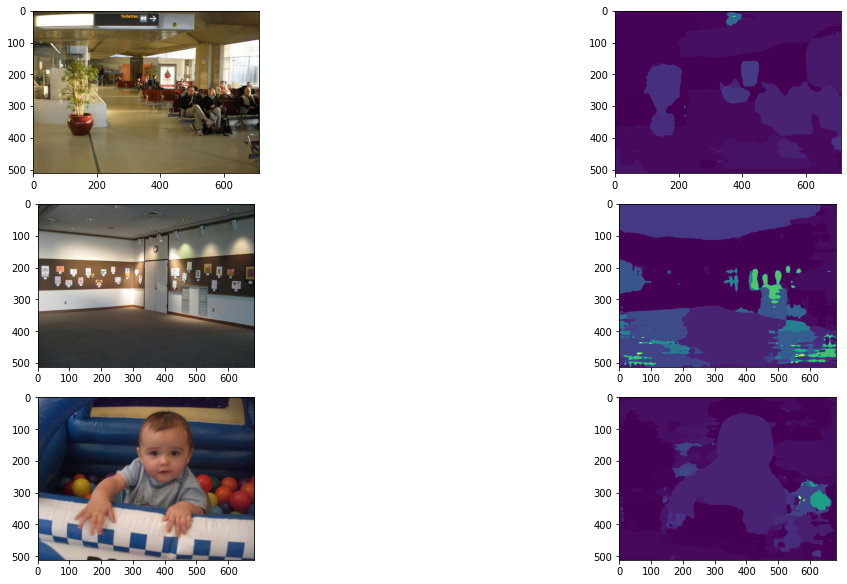

In [ ]:
visualize_performance_on_sample_image(0)

In [ ]:
evaluate_model(new_FCN_model,loss_f,validation_dataloader)

  0%|          | 1/500 [00:10<1:28:23, 10.63s/it]

initial validation loss:  1.3502473831176758
initial validation IOU:  22.315390982426614


 20%|██        | 100/500 [15:30<55:07,  8.27s/it]

validation loss per 100 itr 1.825564455986023
validation mean IOU per 100 itr:  26.997281081208598


 40%|████      | 200/500 [27:06<28:37,  5.73s/it]

validation loss per 100 itr 1.8273177218437195
validation mean IOU per 100 itr:  26.405702415818283


 60%|██████    | 300/500 [36:52<17:29,  5.25s/it]

validation loss per 100 itr 1.867933988571167
validation mean IOU per 100 itr:  25.37143342517176


 80%|████████  | 400/500 [45:36<07:39,  4.60s/it]

validation loss per 100 itr 1.8928779971599579
validation mean IOU per 100 itr:  26.11501832044569


100%|██████████| 500/500 [53:32<00:00,  6.43s/it]

validation loss per 100 itr 1.8851685392856599
validation mean IOU per 100 itr:  25.967953920212523
final mean IOU:  26.17147783257139
test loss:  1.8597725405693055


(1.8597725405693055, 26.17147783257139)

weird thing happen like my previous model is covered and not able to recover so I retrain my model from version 6(which is different as well)

In [ ]:
model_name_610 = "new_FCN610"
path = '/content/drive/MyDrive/6.869/{model_name_610}'
torch.save(new_FCN_model.state_dict(), path)

<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 768])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 342, 500])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 500, 375])


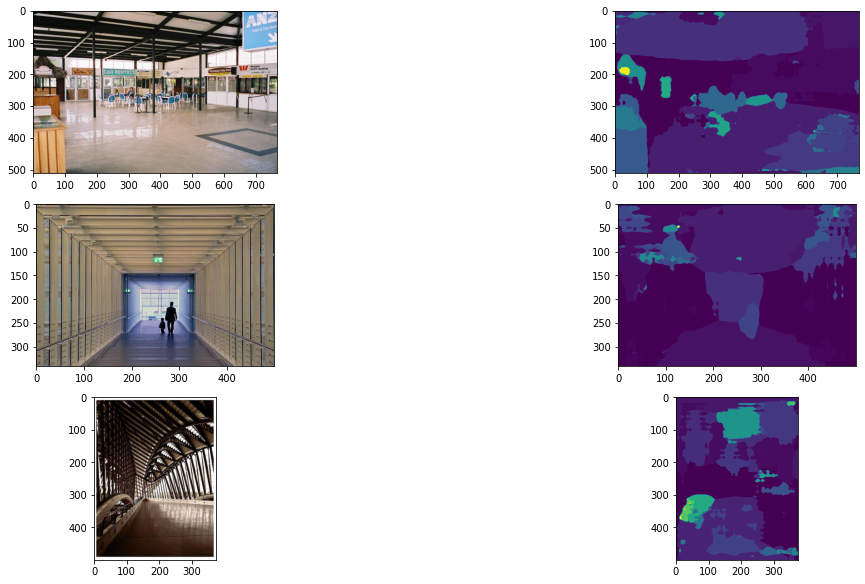

In [38]:
model_name_610 = "new_FCN610"
path = '/content/drive/MyDrive/6.869/{model_name_610}'
new_FCN_model.load_state_dict(torch.load(path))
new_FCN_model.to(device)
visualize_performance_on_sample_image(new_FCN_model,"validation",1)

#DeepLabV3

In [74]:
deeplabv3_model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [75]:
new_deeplabv3 = deeplabv3_model
new_deeplabv3.classifier[4] = nn.Conv2d(256, 150, kernel_size=(1, 1), stride=(1, 1))
new_deeplabv3.aux_classifier[4] = nn.Conv2d(256, 150, kernel_size=(1, 1), stride=(1, 1))

<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 711])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 683])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 683])


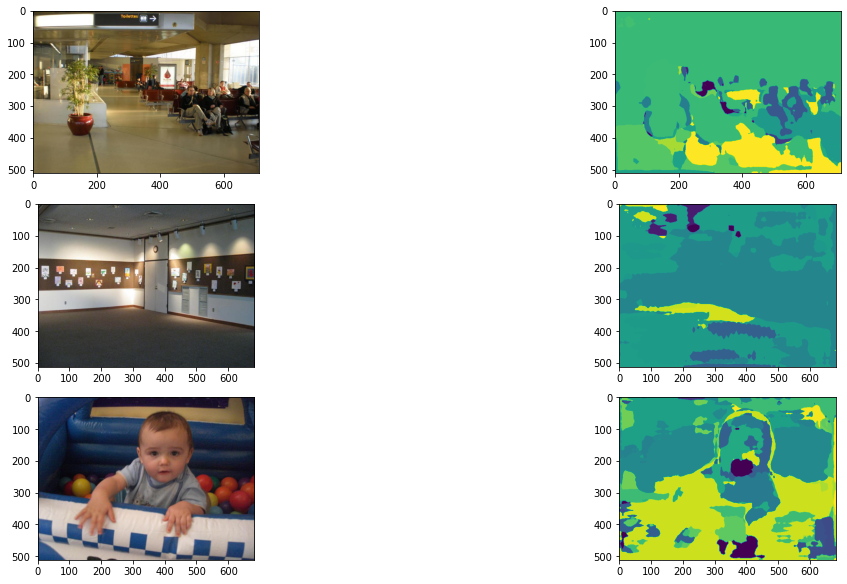

In [76]:
new_deeplabv3.eval()
visualize_performance_on_sample_image(new_deeplabv3,"training",0)

evaluate the pretrained deeplabv3 model

In [ ]:
new_deeplabv3.to(device)
evaluate_model(new_deeplabv3,loss_f,validation_dataloader)

  0%|          | 1/500 [00:04<39:17,  4.72s/it]

initial validation loss:  3.966395854949951
initial validation IOU:  0.012972562707173762


 20%|██        | 100/500 [07:04<27:13,  4.08s/it]

validation loss per 100 itr 4.601539375782013
validation mean IOU per 100 itr:  0.12236684323728345


 40%|████      | 200/500 [13:57<20:16,  4.06s/it]

validation loss per 100 itr 4.588118028640747
validation mean IOU per 100 itr:  0.12418288227612045


 60%|██████    | 300/500 [20:49<13:27,  4.04s/it]

validation loss per 100 itr 4.6430193567276
validation mean IOU per 100 itr:  0.1130997204442564


 80%|████████  | 400/500 [27:38<06:44,  4.04s/it]

validation loss per 100 itr 4.536734807491302
validation mean IOU per 100 itr:  0.24051737885926797


100%|██████████| 500/500 [34:32<00:00,  4.14s/it]

validation loss per 100 itr 4.5351449656486515
validation mean IOU per 100 itr:  0.12978742831825302
final mean IOU:  0.14599085062703626
test loss:  4.580911306858063


(4.580911306858063, 0.14599085062703626)

compare pretrained very first one FCN model

initial loss is 4.58 and iou is only 0.14599. 
 lets train 1 epoachs


In [ ]:
new_deeplabv3.to(device)
optimizer_deep = torch.optim.SGD(new_deeplabv3.parameters(), lr=0.001, momentum=0.9)
train_model(new_deeplabv3,train_dataloader,validation_dataloader,optimizer_deep,loss_f,1)

Epoch 1/1
----------


  0%|          | 1/2000 [00:11<6:24:01, 11.53s/it]

initial loss:  4.74440336227417


  3%|▎         | 57/2000 [10:29<5:56:09, 11.00s/it]

In [ ]:
new_deeplabv3.eval()
visualize_performance_on_sample_image(new_deeplabv3,"training",0)

In [ ]:
deeplabv3_1 = "new_deeplabv3_1"
path = '/content/drive/MyDrive/6.869/{deeplabv3_1}'
torch.save(new_deeplabv3.state_dict(), path)

In [ ]:
evaluate_model(new_deeplabv3,loss_f,validation_dataloader)